# Acessar imagens via Google Drive

In [ ]:
from google.colab import drive  # Importa o módulo drive do pacote google.colab
drive.mount('/content/drive')   # Monta o Google Drive no diretório '/content/drive'

Mounted at /content/drive


# Carregamento e Pré-processamento das Imagens

In [ ]:
# Importações necessárias do TensorFlow e outras bibliotecas
from tensorflow.keras import layers, models, optimizers, losses, callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import keras

# Versão do Tensorflow
print(tf.__version__)

# Definindo o número total de imagens presentes no arquivo TFRecord
total_images = 100000

# Calculando o tamanho dos conjuntos de treinamento e validação/teste
train_size = int(0.9 * total_images)  # 90% para treinamento
val_size = test_size = int(0.1 * total_images)  # 10% para validação/teste

# Configurações iniciais: caminho do arquivo TFRecord, dimensão latente e tamanho do batch
tfrecord_file_path = '/content/drive/MyDrive/celeba_subset.tfrecord'  # Caminho do arquivo no Google Drive
latent_dim = 150  # Dimensão do espaço latente para o VAE
batch_size = 32   # Número de exemplos por batch

# Carregando o dataset diretamente do arquivo TFRecord
raw_dataset = tf.data.TFRecordDataset(tfrecord_file_path)

# Embaralhando o dataset completo para misturar as imagens
raw_dataset = raw_dataset.shuffle(buffer_size=total_images)

# Dividindo o dataset em treinamento e validação
train_dataset = raw_dataset.take(train_size)  # Pega a parte de treinamento
val_dataset = raw_dataset.skip(train_size)    # Pula a parte de treinamento e usa o resto para validação

# Função para decodificar cada exemplo do TFRecord
def _parse_function(tfrecord_proto):
    # Descrição das características presentes no TFRecord
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),  # Imagens codificadas como strings
    }
    # Decodifica o exemplo usando a descrição
    parsed_features = tf.io.parse_single_example(tfrecord_proto, feature_description)
    # Decodifica a imagem (string) para um tensor e redimensiona para 128x128 pixels
    image = tf.image.decode_jpeg(parsed_features['image'], channels=3)
    image = tf.image.resize(image, [128, 128])
    # Normaliza os valores dos pixels para o intervalo [-1, 1]
    image = (image / 127.5) - 1.0
    return image, image  # Retorna a imagem como entrada e saída (para autoencoder)

# Função para preprocessar o dataset
def preprocess_dataset(dataset):
    # Aplica a função de decodificação em paralelo, organiza em batches e pré-carrega os próximos batches
    return dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE) \
                  .batch(batch_size) \
                  .prefetch(buffer_size=tf.data.AUTOTUNE)

# Preprocessa os conjuntos de treinamento e validação
train_dataset = preprocess_dataset(train_dataset)
val_dataset = preprocess_dataset(val_dataset)

2.15.0


# Salvar imagens

In [ ]:
# Importa o módulo os para interagir com o sistema de arquivos
import os

# Define o diretório onde as imagens serão salvas
save_dir = '/content/drive/MyDrive/celeba_files'

# Função para salvar imagens
def save_images(images, filename, title='Generated Images'):
    # Configura o tamanho da figura (a área total da plotagem)
    plt.figure(figsize=(10, 10))

    # Loop para iterar sobre cada imagem no batch
    for i in range(images.shape[0]):
        # Cria um subplot para cada imagem. Aqui, assumimos um layout de 4x4.
        plt.subplot(4, 4, i+1)
        # Mostra a imagem no subplot
        plt.imshow(images[i])
        # Adiciona um título ao subplot. Útil se você quiser diferenciar conjuntos de imagens.
        plt.title(title)
        # Remove os eixos para uma visualização mais limpa das imagens
        plt.axis('off')

    # Salva a figura completa com todas as imagens em um arquivo PNG no diretório especificado
    plt.savefig(os.path.join(save_dir, f'{filename}.png'))
    # Fecha a figura para liberar memória
    plt.close()

# Definição do modelo VAE

In [ ]:
class Sampling(layers.Layer):
    """Camada para amostrar z a partir da média e do log da variância."""

    def call(self, inputs):
        # Desempacota os inputs em média e logaritmo da variância.
        z_mean, z_log_var = inputs

        # Obtém o tamanho do batch a partir da primeira dimensão da média.
        batch = tf.shape(z_mean)[0]

        # Obtém a dimensão do espaço latente a partir da segunda dimensão da média.
        dim = tf.shape(z_mean)[1]

        # Gera um vetor de ruído epsilon com distribuição normal padrão.
        # O formato do ruído corresponde ao do batch e da dimensão do espaço latente.
        epsilon = tf.random.normal(shape=(batch, dim))

        # Retorna o vetor latente z, calculado pela adição da média ao produto do
        # ruído epsilon e a exponenciação de metade do logaritmo da variância.
        # Isso permite a amostragem de z mantendo a diferenciabilidade do processo.
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
class Encoder(layers.Layer):
    def __init__(self, latent_dim, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        # Define uma sequência de camadas convolucionais e de tratamento.
        self.conv1 = layers.Conv2D(32, 3, strides=2, padding='same')
        self.leakyrelu1 = layers.LeakyReLU(alpha=0.2)
        self.batchnorm1 = layers.BatchNormalization()
        self.dropout1 = layers.Dropout(0.25)
        self.conv2 = layers.Conv2D(64, 3, strides=2, padding='same')
        self.leakyrelu2 = layers.LeakyReLU(alpha=0.2)
        self.batchnorm2 = layers.BatchNormalization()
        self.dropout2 = layers.Dropout(0.25)
        self.conv3 = layers.Conv2D(128, 3, strides=2, padding='same')
        self.leakyrelu3 = layers.LeakyReLU(alpha=0.2)
        self.batchnorm3 = layers.BatchNormalization()
        self.dropout3 = layers.Dropout(0.25)
        self.conv4 = layers.Conv2D(256, 3, strides=2, padding='same')
        self.leakyrelu4 = layers.LeakyReLU(alpha=0.2)
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(latent_dim * 2)  # Saída para média e log var.

    def call(self, inputs):
        # Aplica sequencialmente as camadas definidas no __init__.
        x = self.conv1(inputs)
        x = self.leakyrelu1(x)
        x = self.batchnorm1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.leakyrelu2(x)
        x = self.batchnorm2(x)
        x = self.dropout2(x)
        x = self.conv3(x)
        x = self.leakyrelu3(x)
        x = self.batchnorm3(x)
        x = self.dropout3(x)
        x = self.conv4(x)
        x = self.leakyrelu4(x)
        x = self.flatten(x)
        x = self.dense(x)
        # Divide a saída densa em duas partes iguais para média e log var.
        z_mean, z_log_var = tf.split(x, num_or_size_splits=2, axis=1)
        return z_mean, z_log_var

encoder = Encoder(latent_dim) # Instancia o encoder

decoder = keras.Sequential([
    # Inicia a decodificação a partir da dimensão latente.
    layers.InputLayer(input_shape=(latent_dim,)),
    layers.Dense(8*8*256),  # Expande para dimensão que permite "desdobramento".
    layers.LeakyReLU(alpha=0.2),
    layers.Reshape((8, 8, 256)),  # Redimensiona para forma espacial.
    # Sequência de camadas de convolução transposta para "upsampling".
    layers.Conv2DTranspose(256, 3, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Conv2DTranspose(128, 3, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Conv2DTranspose(64, 3, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Conv2DTranspose(32, 3, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    # Camada final para produzir a imagem reconstruída.
    layers.Conv2DTranspose(3, 3, padding='same', activation='sigmoid'),
])

beta=0.6  # Fator de ponderação da perda KL.
vae = VAE(encoder, decoder, latent_dim=latent_dim, beta=beta)
vae.compile(optimizer=optimizers.Adam(1e-4))  # Compila o VAE com um otimizador Adam.

In [ ]:
class VAE(keras.Model):
    """Modelo Variational Autoencoder."""

    def __init__(self, encoder, decoder, latent_dim, beta=1.0, **kwargs):
        super(VAE, self).__init__(**kwargs)
        # Inicializa o encoder e o decoder fornecidos como parte do VAE.
        self.encoder = encoder
        self.decoder = decoder

        # Dimensão do espaço latente.
        self.latent_dim = latent_dim

        # Fator beta para ponderar a perda KL na perda total.
        self.beta = beta

        # Rastreadores para as métricas de perda total, de reconstrução e KL.
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def call(self, inputs, training=None):
        # Passa os dados de entrada pelo encoder para obter a média e log variância.
        z_mean, z_log_var = self.encoder(inputs)

        # Amostra `z` do espaço latente usando a média e log variância.
        z = Sampling()(inputs=[z_mean, z_log_var])

        # Passa `z` pelo decoder para obter a reconstrução.
        reconstructed = self.decoder(z)
        return reconstructed

    @property
    def metrics(self):
        # Retorna as métricas de perda para serem rastreadas.
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        # Desempacota os dados; assume-se que `data` é uma tupla de (entrada, alvo).
        x, _ = data
        with tf.GradientTape() as tape:
            # Calcula a média e log variância do encoder, e a reconstrução do decoder.
            z_mean, z_log_var = self.encoder(x)
            z = Sampling()(inputs=[z_mean, z_log_var])
            reconstruction = self.decoder(z)

            # Calcula a perda de reconstrução como a média do erro quadrático.
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - reconstruction), axis=[1, 2, 3]))

            # Calcula a perda KL como especificado na fórmula do VAE.
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))

            # Calcula a perda total combinando as perdas de reconstrução e KL.
            total_loss = reconstruction_loss + self.beta * kl_loss

        # Calcula os gradientes e aplica-os aos parâmetros do modelo.
        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        # Atualiza as métricas de perda.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        # Retorna um dicionário com os valores atuais das métricas de perda.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        # Processo similar ao `train_step`, mas sem o uso de `tf.GradientTape`
        # pois não estamos atualizando os parâmetros durante a avaliação.
        x, _ = data  # Assume-se que data é uma tupla de (entrada, alvo).
        z_mean, z_log_var = self.encoder(x, training=False)
        z = Sampling()(inputs=[z_mean, z_log_var])
        reconstruction = self.decoder(z, training=False)

        reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - reconstruction), axis=(1, 2, 3)))
        kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
        total_loss = reconstruction_loss + self.beta * kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

# Callback para salvar o melhor modelo durante o treinamento.
model_checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/celeba_files/',  # Define o caminho onde o modelo será salvo.
    save_weights_only=True,  # Se True, apenas os pesos do modelo são salvos.
    monitor='val_loss',  # A métrica a ser monitorada, neste caso, a perda de validação.
    mode='min',  # Define que o objetivo é minimizar a métrica monitorada.
    save_best_only=True,  # Se True, salva somente o melhor modelo segundo a métrica monitorada.
    verbose=1  # Ativa mensagens de log durante o treinamento.
)

# Callback customizado para salvar imagens geradas no fim do treinamento.
class SaveFinalGeneratedImages(Callback):
    def __init__(self, latent_dim, num_images=16):
        self.latent_dim = latent_dim  # Dimensão do espaço latente.
        self.num_images = num_images  # Número de imagens a serem geradas.

    def on_train_end(self, logs=None):
        # Gera vetores latentes aleatórios.
        latent_vectors = np.random.normal(size=(self.num_images, self.latent_dim))
        # Usa o decoder para gerar imagens a partir dos vetores latentes.
        generated_images = self.model.decoder.predict(latent_vectors)
        # Normaliza as imagens para o intervalo [0, 255] e converte para uint8.
        generated_images = (generated_images * 127.5 + 127.5).astype(np.uint8)
        # Salva as imagens geradas.
        save_images(generated_images, 'final_generated_images')

# Callback customizado para salvar gráficos de perda durante o treinamento.
class SaveLossGraphs(Callback):
    def on_train_begin(self, logs=None):
        # Inicializa listas para armazenar os valores de perda durante o treinamento.
        self.losses = []
        self.val_losses = []
        self.kl_losses = []
        self.reconstruction_losses = []

    def on_epoch_end(self, epoch, logs=None):
        # Atualiza as listas de perdas ao final de cada época.
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.kl_losses.append(logs.get('kl_loss'))
        self.reconstruction_losses.append(logs.get('reconstruction_loss'))

    def on_train_end(self, logs=None):
        # Gera e salva os gráficos de perda ao final do treinamento.
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(self.losses, label='Training Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.title('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.kl_losses, label='KL Loss')
        plt.plot(self.reconstruction_losses, label='Reconstruction Loss')
        plt.title('KL and Reconstruction Loss')
        plt.legend()

        plt.savefig(f'{save_dir}/training_progress.png')
        plt.close()

# Callback para interromper o treinamento caso a perda de validação não melhore.
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitora a perda de validação.
    patience=50,  # Interrompe o treinamento se não houver melhora após 50 épocas.
    verbose=1,  # Ativa mensagens de log.
    restore_best_weights=True  # Restaura os melhores pesos ao final.
)

# Callback para reduzir o learning rate se a perda de validação não melhorar.
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',  # Monitora a perda de validação.
    factor=0.5,  # Fator de redução do learning rate.
    patience=20,  # Número de épocas a esperar antes de reduzir o learning rate.
    min_lr=1e-6,  # Valor mínimo para o learning rate.
    verbose=1  # Ativa mensagens de log.
)

# Instancia os callbacks customizados para salvar imagens e gráficos de perda.
image_callback = SaveFinalGeneratedImages(latent_dim=latent_dim)
loss_graph_callback = SaveLossGraphs()

# Treinamento do Modelo

In [ ]:
# Define o caminho para o diretório onde os pesos do modelo estão salvos.
weights_path = '/content/drive/MyDrive/celeba_files/'
# Carrega os pesos salvos anteriormente no modelo VAE.
vae.load_weights(weights_path)

# Inicia o treinamento do modelo.
history = vae.fit(
    train_dataset,  # O dataset de treinamento.
    epochs=200,  # Número total de épocas para treinar o modelo.
    batch_size=batch_size,  # Tamanho do lote usado no treinamento.
    validation_data=val_dataset,  # O dataset de validação para avaliar o modelo após cada época.
    callbacks=[  # Lista de callbacks para serem aplicados durante o treinamento.
        image_callback,  # Callback personalizado para salvar imagens geradas no fim do treinamento.
        loss_graph_callback,  # Callback personalizado para salvar gráficos de perda após o treinamento.
        reduce_lr_callback,  # Callback para reduzir o learning rate se a perda de validação parar de melhorar.
        model_checkpoint_callback  # Callback para salvar o modelo ou pesos com o melhor desempenho em val_loss.
    ]
)

Epoch 1/50
   2812/Unknown - 162s 56ms/step - loss: 12286.1890 - reconstruction_loss: 12149.0244 - kl_loss: 247.3493
Epoch 1: val_loss improved from 12326.62207 to 12273.53418, saving model to /content/drive/MyDrive/celeba_files/
2813/2813 [==============================] - 173s 60ms/step - loss: 12286.1970 - reconstruction_loss: 12149.0098 - kl_loss: 247.3563 - val_loss: 12273.5342 - val_reconstruction_loss: 12124.0684 - val_kl_loss: 249.1097 - lr: 1.2500e-05
Epoch 2/50
2812/2813 [============================>.] - ETA: 0s - loss: 12305.8794 - reconstruction_loss: 12150.1279 - kl_loss: 247.4571
Epoch 2: val_loss did not improve from 12273.53418
2813/2813 [==============================] - 171s 60ms/step - loss: 12305.8741 - reconstruction_loss: 12149.9697 - kl_loss: 247.4436 - val_loss: 12406.2812 - val_reconstruction_loss: 12258.0742 - val_kl_loss: 247.0085 - lr: 1.2500e-05
Epoch 3/50
2812/2813 [============================>.] - ETA: 0s - loss: 12289.7536 - reconstruction_loss: 12141.

# Geração de Imagens

1/1 [==============================] - 0s 18ms/step


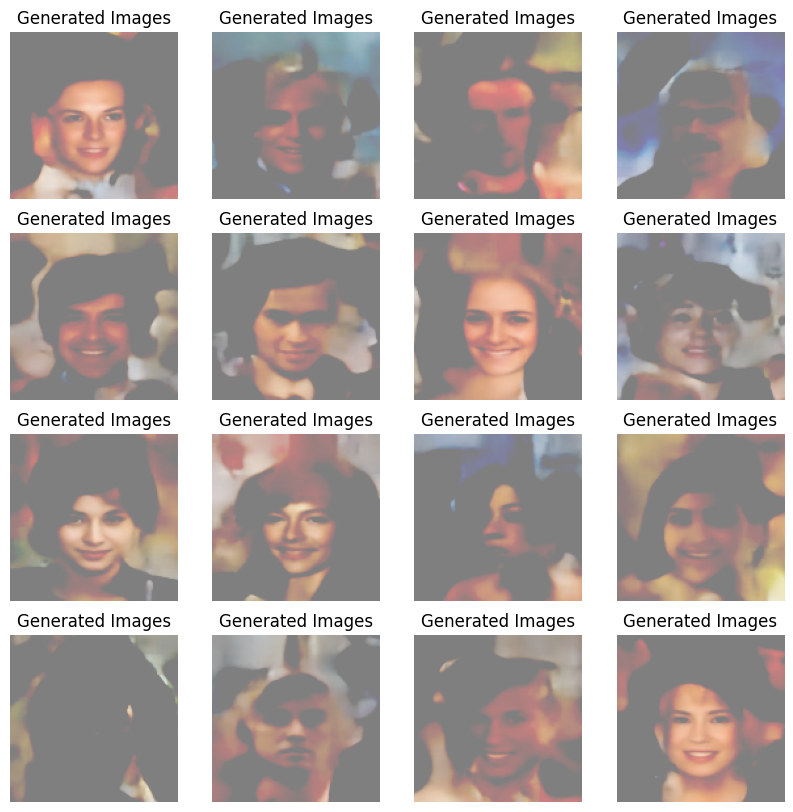

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def display_images(images, title=''):
    # Inicializa uma figura do matplotlib com um tamanho específico.
    plt.figure(figsize=(10,10))
    # Itera sobre o conjunto de imagens para exibi-las individualmente.
    for i in range(images.shape[0]):
        plt.subplot(4, 4, i + 1)  # Prepara o subplot para a imagem atual.
        plt.imshow(images[i])  # Mostra a imagem no subplot.
        plt.title(title)  # Adiciona um título ao subplot, se fornecido.
        plt.axis('off')  # Remove os eixos para uma visualização limpa.
    plt.show()  # Exibe a figura com todas as imagens.

# Geração de imagens a partir do espaço latente.
latent_vectors = np.random.normal(size=(16, latent_dim))  # Gera 16 vetores latentes aleatórios.
generated_images = vae.decoder.predict(latent_vectors)  # Usa o decoder do VAE para gerar imagens a partir dos vetores latentes.
generated_images = (generated_images * 127.5 + 127.5).astype(np.uint8)  # Normaliza as imagens para o intervalo [0, 255] e converte para uint8.

# Exibição das imagens geradas.
display_images(generated_images, 'Generated Images')  # Chama a função para exibir as imagens geradas com um título.